### 원문 벡터 db + QA 벡터 DB -> 답변 평가 후 -> HyDE 재실행
```
extract_queries → split_queries → tool → qa_tool → basic 
→ evaluate ── good → END
            └─ bad → hyde → tool → qa_tool → basic → evaluate → END
```

In [ ]:
from pathlib import Path
import sys

root = Path.cwd()
while not (root / "utils_v5").exists() and root != root.parent:
    root = root.parent
sys.path.insert(0, str(root))

from utils_v5.main3 import (run_langraph)

c:\Users\playdata2\miniconda3\envs\final-clean\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Workspaces\SKN14-Final-1Team-AI\LLM_hybrid\utils_v52\retriever.py:51: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vs = Chroma(


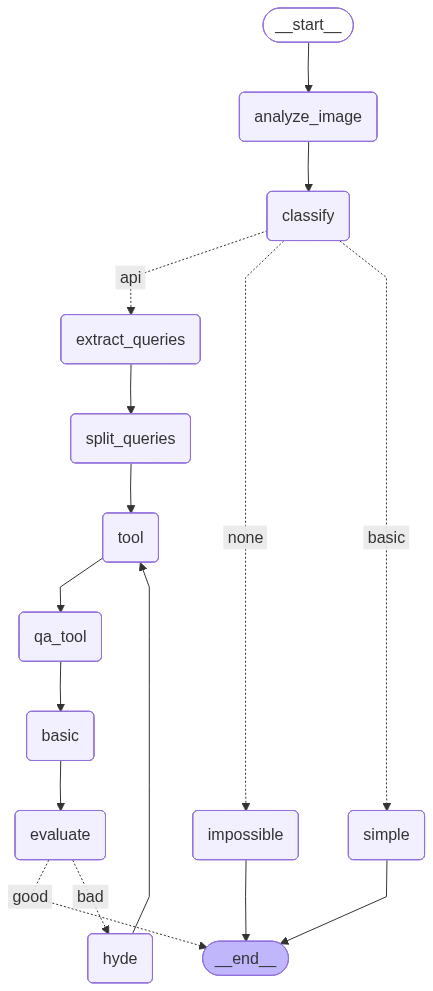

In [ ]:
from utils_v5.langgraph_setting2 import graph_setting

graph = graph_setting()

graph

In [ ]:
response = run_langraph('Firebase의 updateTime 필드에 사용되는 시간 형식이 뭐야?', '1', None)
print(response)

In [3]:
response = run_langraph('GMSMapPoint의 좌표계에서 (0, 0)은 어떤 지점을 의미하나요?', '1', None)
print(response)

run_langraph 호출 - 입력: GMSMapPoint의 좌표계에서 (0, 0)은 어떤 지점을 의미하나요?, 이미지: False
analyze_image 호출됨 - 이미지 존재: False
[tool_based_search_node] 실행 - queries=['GMSMapPoint의 좌표계에서 (0, 0)은 어떤 지점을 의미하나요?']
[vector_search_tool] 검색 실행 - query='GMSMapPoint의 좌표계에서 (0, 0)은 어떤 지점을 의미하나요?', filters={'tags': {'$in': ['map']}}
[tool_based_search_node] 전달 인자: ['GMSProjection [https://developers.google.com/maps/documentation/navigation/ios-sdk/reference/objc/Classes/GMSProjection]\nDefines a mapping between Earth coordinates CLLocationCoordinate2D and coordinates in the map’s view CGPoint. A projection is constant and immutable, in that the mapping it embodies never changes. The mapping is not necessarily linear.\nPassing invalid Earth coordinates (i.e., per CLLocationCoordinate2DIsValid) to this object may result in undefined behavior.\nThis class should not be instantiated directly unless under testing conditions. Instead, obtain it via projection on GMSMapView [https://developers.google.com/maps/documentati

In [4]:
print(response['answer'])
# # print(response['tool_calls'])
# print(response['qa_tool_calls'])

죄송합니다. 제공된 문서에는 GMSMapPoint의 좌표계에서 (0, 0)이 어떤 지점을 의미하는지에 대한 정보가 없습니다. 다른 질문이 있으시면 도와드리겠습니다.


In [ ]:
## 환경설정
# !pip install -qU ragas langchain langchain-community langchain-openai langchain-chroma langchain-text-splitters pypdf rapidfuzz langgraph gdown chromadb langchain-huggingface sentence-transformers -q

In [ ]:
# !pip install ragas

In [5]:
import os
from dotenv import load_dotenv

load_dotenv()
# 필요한 라이브러리 임포트
import os
import pandas as pd
from pprint import pprint
# LangChain 관련 라이브러리
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
# RAGAS 관련 라이브러리
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.testset.persona import Persona
from ragas.testset import TestsetGenerator
from ragas import EvaluationDataset, evaluate
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness

## 이미 생성된 합성 데이터셋 생성

In [6]:
import pandas as pd

# 같은 폴더(현재 작업 디렉토리)에 저장했다면
dataset_df = pd.read_csv("./dataset.csv")
print(dataset_df.shape)
display(dataset_df)

(20, 3)


,user_input,reference_contexts,reference
0,Analytics Hub 게시자와 목록 관리자 역할의 차이점은 무엇인가요?,사용자가 다음 작업을 수행할 수 있게 해주는 Analytics Hub 게시자 역할(...,"Analytics Hub 게시자 역할은 목록을 생성, 업데이트, 삭제하고 목록에 I..."
1,BigQuery Studio 저장된 쿼리에 공개 액세스 권한을 방지하려면 어떻게 해...,BigQuery Studio 저장된 쿼리에 공개 액세스 권한이 부여되지 않도록 하려...,BigQuery Studio 저장된 쿼리에 공개 액세스 권한을 방지하려면 프로젝트에...
2,calendarId에 primary 키워드를 사용하면 어떤 캘린더에 접근할 수 있나요?,현재 로그인한 사용자의 기본 캘린더에 액세스하려면 'primary' 키워드를 사용하세요.,calendarId에 primary 키워드를 사용하면 현재 로그인한 사용자의 기본 ...
3,Google Drive API v3의 서비스 엔드포인트가 궁금해,"이 서비스에는 다음 서비스 엔드포인트가 포함되고, 그 아래의 모든 URI가 이 서비...",Google Drive API v3의 서비스 엔드포인트는 https://www.go...
4,files.create 메서드의 최대 파일 크기와 허용되는 미디어 MIME 유형은 ...,"최대 파일 크기: 5,120GB\r\n허용되는 미디어 MIME 유형: */*\r\n...","files.create 메서드의 최대 파일 크기는 5,120GB입니다. 허용되는 미..."
5,Firebase scrypt 해시 비밀번호를 사용한 사용자 가져오는 방법은?,기본적으로 Firebase는 scrypt 해싱 알고리즘의 수정된 Firebase 버...,"Firebase scrypt 해시 비밀번호를 사용한 사용자를 가져오려면, 먼저 Fi..."
6,커스텀 인증 시스템으로 Firebase에 인증하려면 어떻게 해야 하나요?,Firebase 인증에 맞춤 인증 시스템을 통합할 수 있습니다. 사용자가 정상적으로...,"커스텀 인증 시스템으로 Firebase에 인증하려면, 먼저 인증 서버에서 사용자의 ..."
7,"Firestore에서 맵 필드에 대한 단일 필드 색인 예외를 설정하면, 하위 필드들...",맵 필드에 단일 필드 색인 예외를 만들면 맵의 하위 필드에서 해당 설정을 상속합니다...,"네, Firestore에서 맵 필드에 단일 필드 색인 예외를 만들면 맵의 하위 필드..."
8,Firebase의 updateTime 필드에 사용되는 시간 형식이 뭐야?,"Uses RFC 3339, where generated output will alw...",Firebase의 updateTime 필드에는 RFC 3339 시간 형식이 사용됩니...
9,Firefox 58 환경에서 Gmail의 AMP 렌더링 기능이 호환되나요?,브라우저 최소 버전\r\nChrome 69\r\nEdge 지원되지 않음\r\nFir...,"네, Firefox 58 환경에서는 Gmail의 AMP 렌더링 기능이 호환됩니다. ..."


In [7]:

## 02.RAG 체인 구성

import pandas as pd
from datasets import Dataset
import uuid
import time


evaluated_dataset = []

for _, row in dataset_df.iterrows():
    time.sleep(3)
    query = row.user_input  # 사용자 입력 - 합성 데이터셋에서 가져옴

    # run_langraph 함수 호출
    rag_result = run_langraph(query,'1', None)

    evaluated_dataset.append(
        {
            "user_input": query,
            "retrieved_contexts": [doc for doc in rag_result["search_results"]],
            "response": rag_result["answer"],
            "reference": row['reference']
        }
    )

print("평가 데이터셋 준비 완료")

# RAGAS 평가 데이터셋 생성
ragas_evaluated_dataset = Dataset.from_list(evaluated_dataset)
# csv 데이터 저장
# ragas_evaluated_dataset.to_pandas().to_csv('ragas_evaluated_dataset_hybrid4.csv', index=False)
ragas_evaluated_dataset.to_pandas().info()

run_langraph 호출 - 입력: Analytics Hub 게시자와 목록 관리자 역할의 차이점은 무엇인가요?, 이미지: False
analyze_image 호출됨 - 이미지 존재: False
[tool_based_search_node] 실행 - queries=['Analytics Hub에서 게시자 역할과 목록 관리자 역할의 차이점은 무엇인가요?']
[vector_search_tool] 검색 실행 - query='Analytics Hub에서 게시자 역할과 목록 관리자 역할의 차이점은 무엇인가요?', filters={'tags': {'$in': ['bigquery']}}
[tool_based_search_node] 전달 인자: ['데이터 교환을 생성, 업데이트, 삭제합니다.\n목록을 생성, 업데이트, 삭제, 공유\nAnalytics Hub 관리자, 목록 관리자, 게시자, 구독자, 뷰어를 관리합니다.\n이 역할을 가진 사용자는 관리자라고 합니다.\nAnalytics Hub 게시자 및 목록 관리자 역할\nSharing은 목록을 관리 [https://cloud.google.com/bigquery/docs/analytics-hub-manage-listings?hl=ko]할 수 있도록 프로젝트, 데이터 교환 또는 목록에 부여할 수 있는 다음과 같은 사전 정의된 역할을 제공합니다.\n사용자가 다음 작업을 수행할 수 있게 해주는 Analytics Hub 게시자 역할(roles/analyticshub.publisher)\n목록 생성, 업데이트, 삭제\n목록에 IAM 정책 설정 [https://cloud.google.com/bigquery/docs/analytics-hub-grant-roles?hl=ko#grant-role-listing]\n이 역할을 가진 사용자를 게시자라고 합니다.\n사용자가 다음 작업을 수행할 수 있게 해주는 Analytics Hub 목록 관리자 역할(roles/analyticshub.listingAdmin)\n목록 업데이트 및 삭제\n목록에 IAM 정

In [8]:
### RAGAS 평가 실행

# LLM 래퍼 생성
evaluator_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
evaluator_llm = LangchainLLMWrapper(evaluator_llm)

# 평가 메트릭 정의
metrics = [
    LLMContextRecall(),  # 검색된 컨텍스트의 회수율
    Faithfulness(),  # 생성된 답변의 충실도
    FactualCorrectness()  # 사실적 정확성
]
# 평가 실행

result = evaluate(
    dataset=ragas_evaluated_dataset,
    metrics=metrics,
    llm=evaluator_llm,
)

print(result)
# 결과를 DataFrame으로 변환
result_df = result.to_pandas()

# 결과 저장
# result_df.to_csv('ragas_evaluation_result_hybrid4.csv', index=False)

display(result_df.head())
result_df[['context_recall', 'faithfulness', 'factual_correctness(mode=f1)']].describe()

Evaluating: 100%|██████████| 60/60 [02:51<00:00,  2.86s/it]


{'context_recall': 0.9500, 'faithfulness': 0.8973, 'factual_correctness(mode=f1)': 0.6180}


,user_input,retrieved_contexts,response,reference,context_recall,faithfulness,factual_correctness(mode=f1)
0,Analytics Hub 게시자와 목록 관리자 역할의 차이점은 무엇인가요?,"[데이터 교환을 생성, 업데이트, 삭제합니다.\n목록을 생성, 업데이트, 삭제, 공...",Analytics Hub 게시자 역할과 목록 관리자 역할의 차이점은 다음과 같습니다...,"Analytics Hub 게시자 역할은 목록을 생성, 업데이트, 삭제하고 목록에 I...",1.0,1.0,0.91
1,BigQuery Studio 저장된 쿼리에 공개 액세스 권한을 방지하려면 어떻게 해...,[탐색기 창에서 프로젝트와 쿼리 폴더를 펼치고 필요한 경우 공유 쿼리 폴더를 펼칩니...,BigQuery Studio 저장된 쿼리에 공개 액세스 권한을 방지하려면 프로젝트에...,BigQuery Studio 저장된 쿼리에 공개 액세스 권한을 방지하려면 프로젝트에...,1.0,1.0,0.91
2,calendarId에 primary 키워드를 사용하면 어떤 캘린더에 접근할 수 있나요?,[이 페이지는 Cloud Translation API [https://cloud.g...,현재 로그인한 사용자의 기본 캘린더에 접근하기 위해서는 `primary` 키워드를 ...,calendarId에 primary 키워드를 사용하면 현재 로그인한 사용자의 기본 ...,1.0,1.0,1.00
3,Google Drive API v3의 서비스 엔드포인트가 궁금해,[https://www.googleapis.com/discovery/v1/apis/...,Google Drive API v3의 서비스 엔드포인트는 `https://www.g...,Google Drive API v3의 서비스 엔드포인트는 https://www.go...,1.0,0.5,0.00
4,files.create 메서드의 최대 파일 크기와 허용되는 미디어 MIME 유형은 ...,[이 페이지는 Cloud Translation API [https://cloud.g...,files.create 메서드를 사용하여 파일을 업로드할 때 지원되는 최대 파일 크...,"files.create 메서드의 최대 파일 크기는 5,120GB입니다. 허용되는 미...",1.0,1.0,0.57


,context_recall,faithfulness,factual_correctness(mode=f1)
count,20.000000,20.000000,20.000000
mean,0.950000,0.897308,0.618000
std,0.223607,0.195038,0.320421
min,0.000000,0.500000,0.000000
25%,1.000000,0.961538,0.500000
50%,1.000000,1.000000,0.665000
75%,1.000000,1.000000,0.850000
max,1.000000,1.000000,1.000000


In [9]:
display(result_df)

,user_input,retrieved_contexts,response,reference,context_recall,faithfulness,factual_correctness(mode=f1)
0,Analytics Hub 게시자와 목록 관리자 역할의 차이점은 무엇인가요?,"[데이터 교환을 생성, 업데이트, 삭제합니다.\n목록을 생성, 업데이트, 삭제, 공...",Analytics Hub 게시자 역할과 목록 관리자 역할의 차이점은 다음과 같습니다...,"Analytics Hub 게시자 역할은 목록을 생성, 업데이트, 삭제하고 목록에 I...",1.0,1.000000,0.91
1,BigQuery Studio 저장된 쿼리에 공개 액세스 권한을 방지하려면 어떻게 해...,[탐색기 창에서 프로젝트와 쿼리 폴더를 펼치고 필요한 경우 공유 쿼리 폴더를 펼칩니...,BigQuery Studio 저장된 쿼리에 공개 액세스 권한을 방지하려면 프로젝트에...,BigQuery Studio 저장된 쿼리에 공개 액세스 권한을 방지하려면 프로젝트에...,1.0,1.000000,0.91
2,calendarId에 primary 키워드를 사용하면 어떤 캘린더에 접근할 수 있나요?,[이 페이지는 Cloud Translation API [https://cloud.g...,현재 로그인한 사용자의 기본 캘린더에 접근하기 위해서는 `primary` 키워드를 ...,calendarId에 primary 키워드를 사용하면 현재 로그인한 사용자의 기본 ...,1.0,1.000000,1.00
3,Google Drive API v3의 서비스 엔드포인트가 궁금해,[https://www.googleapis.com/discovery/v1/apis/...,Google Drive API v3의 서비스 엔드포인트는 `https://www.g...,Google Drive API v3의 서비스 엔드포인트는 https://www.go...,1.0,0.500000,0.00
4,files.create 메서드의 최대 파일 크기와 허용되는 미디어 MIME 유형은 ...,[이 페이지는 Cloud Translation API [https://cloud.g...,files.create 메서드를 사용하여 파일을 업로드할 때 지원되는 최대 파일 크...,"files.create 메서드의 최대 파일 크기는 5,120GB입니다. 허용되는 미...",1.0,1.000000,0.57
5,Firebase scrypt 해시 비밀번호를 사용한 사용자 가져오는 방법은?,[Source URL: https://firebase.google.com/docs/...,Firebase scrypt 해시 비밀번호를 사용한 사용자를 가져오는 방법은 다음과...,"Firebase scrypt 해시 비밀번호를 사용한 사용자를 가져오려면, 먼저 Fi...",1.0,1.000000,0.75
6,커스텀 인증 시스템으로 Firebase에 인증하려면 어떻게 해야 하나요?,[Source URL: https://firebase.google.com/docs/...,Firebase에 커스텀 인증 시스템을 통합하려면 다음과 같은 단계를 수행해야 합니...,"커스텀 인증 시스템으로 Firebase에 인증하려면, 먼저 인증 서버에서 사용자의 ...",1.0,0.846154,0.64
7,"Firestore에서 맵 필드에 대한 단일 필드 색인 예외를 설정하면, 하위 필드들...",[맵 필드에 단일 필드 색인 예외를 만들면 맵의 하위 필드에서 해당 설정을 상속합니...,"네, Firestore에서 맵 필드에 대한 단일 필드 색인 예외를 설정하면, 맵의 ...","네, Firestore에서 맵 필드에 단일 필드 색인 예외를 만들면 맵의 하위 필드...",1.0,1.000000,0.75
8,Firebase의 updateTime 필드에 사용되는 시간 형식이 뭐야?,"[웹 버전 9\nimport { doc, setDoc, Timestamp } fro...",Firebase의 updateTime 필드에 사용되는 시간 형식은 RFC 3339 ...,Firebase의 updateTime 필드에는 RFC 3339 시간 형식이 사용됩니...,1.0,1.000000,0.50
9,Firefox 58 환경에서 Gmail의 AMP 렌더링 기능이 호환되나요?,[Source URL: https://developers.google.com/wor...,"네, Firefox 58 환경에서는 Gmail의 AMP 렌더링 기능이 호환됩니다. ...","네, Firefox 58 환경에서는 Gmail의 AMP 렌더링 기능이 호환됩니다. ...",1.0,1.000000,0.50
